In [1]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("hf")
secret_value_1 = user_secrets.get_secret("wandb-key")

## Set-up environment

Run the cells below to setup the environment

In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install huggingface_hub


In [3]:
!pip install -q datasets

In [4]:
from tqdm.notebook import trange, tqdm

In [5]:
import huggingface_hub as hf
hf.login(token = secret_value_0)

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Load the image captioning dataset

Let's load the image captioning dataset, you just need few lines of code for that. The dataset only consists of 6 images that we have manually labeled for the sake of the tutorial.

In [6]:
from datasets import load_dataset 

dataset = load_dataset("astro21/private_gans_split", split="train")

Generating train split:   0%|          | 0/106834 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/13354 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/13355 [00:00<?, ? examples/s]

Let's retrieve the caption of the first example:

In [7]:
dataset = dataset.rename_column("caption", "text")
dataset = dataset.remove_columns("folder")

In [8]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 106834
})

In [9]:
dataset[0]["text"]

'illustration of location error using inertial sensors : actual vs. estimated when under attack trajectory .'

And the corresponding image

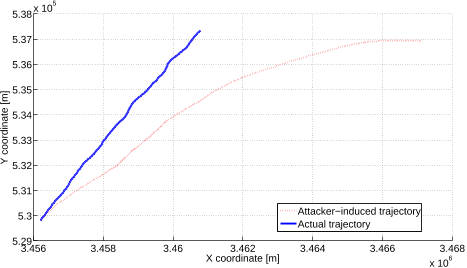

In [10]:
dataset[0]["image"]

## Create PyTorch Dataset

### Understanding `max_patches` argument

The paper introduces a new paradigm for processing the input image. It takes the image and create `n_patches` aspect-ratio preserving patches, and concatenates the remaining sequence with padding tokens to finally get `max_patches` patches. It appears that this argument is quite crucial for training and evaluation, as the model becomes very sensitive to this parameter.

For the sake of our example, we will fine-tune a model with `max_patches=1024`.

Note that most of the `-base` models have been fine-tuned with `max_patches=2048`, and `4096` for `-large` models.

In [11]:
from torch.utils.data import Dataset, DataLoader

MAX_PATCHES = 1024

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], return_tensors="pt", add_special_tokens=True, max_patches=MAX_PATCHES)
        
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding

## Load model and processor

In [12]:
# from transformers import Pix2StructForConditionalGeneration, Pix2StructProcessor

# model = Pix2StructForConditionalGeneration.from_pretrained(PATH_TO_SAVE)
# processor = Pix2StructProcessor.from_pretrained(PATH_TO_SAVE)




In [13]:
from transformers import AutoProcessor, Pix2StructForConditionalGeneration

processor = AutoProcessor.from_pretrained("ybelkada/pix2struct-base")
model = Pix2StructForConditionalGeneration.from_pretrained("ybelkada/pix2struct-base")

2024-04-11 08:47:54.922618: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 08:47:54.922720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 08:47:55.153413: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/231 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.61k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/851k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

Now that we have loaded the processor, let's load the dataset and the dataloader:

In [14]:
def collator(batch):
  new_batch = {"flattened_patches":[], "attention_mask":[]}
  texts = [item["text"] for item in batch]
  
  text_inputs = processor(text=texts, padding="max_length", return_tensors="pt", add_special_tokens=True, max_length=30 , truncation=True)
  
  new_batch["labels"] = text_inputs.input_ids
  
  for item in batch:
    new_batch["flattened_patches"].append(item["flattened_patches"])
    new_batch["attention_mask"].append(item["attention_mask"])
  
  new_batch["flattened_patches"] = torch.stack(new_batch["flattened_patches"])
  new_batch["attention_mask"] = torch.stack(new_batch["attention_mask"])

  return new_batch

In [15]:
import random

# Determine the desired size of the reduced training dataset
desired_train_size = int(len(dataset) * 0.1)  # Reduce the size by 60%

# Randomly sample examples from the original training dataset to create the reduced training dataset
reduced_train_dataset = dataset.shuffle(seed=42).select(range(desired_train_size))

In [16]:
reduced_train_dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 10683
})

In [17]:
train_dataset = ImageCaptioningDataset(reduced_train_dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2, collate_fn=collator)

In [18]:
from accelerate import Accelerator
accelerator = Accelerator()

## Train the model

Let's train the model! Run the simply the cell below for training the model. We have observed that finding the best hyper-parameters was quite challenging and required a lot of trials and errors, as the model can easily enter in "collapse-model" (always predicting the same output, no matter the input) if the HP are not chosen correctly. In this example, we found out that using `AdamW` optimizer with `lr=1e-5` seemed to be the best approach.

Let's also print the generation output of the model each 20 epochs!

Bear in mind that the model took some time to converge, for instance to get decent results we had to let the script run for ~1hour. 

In [19]:
import torch
torch.cuda.empty_cache()

In [20]:
import torch

EPOCHS = 10

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)




Pix2StructForConditionalGeneration(
  (encoder): Pix2StructVisionModel(
    (embeddings): Pix2StructVisionEmbeddings(
      (patch_projection): Linear(in_features=768, out_features=768, bias=True)
      (row_embedder): Embedding(4096, 768)
      (column_embedder): Embedding(4096, 768)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): Pix2StructVisionEncoder(
      (layer): ModuleList(
        (0-11): 12 x Pix2StructVisionLayer(
          (attention): Pix2StructVisionAttention(
            (query): Linear(in_features=768, out_features=768, bias=False)
            (key): Linear(in_features=768, out_features=768, bias=False)
            (value): Linear(in_features=768, out_features=768, bias=False)
            (output): Linear(in_features=768, out_features=768, bias=False)
          )
          (mlp): Pix2StructVisionMlp(
            (wi_0): Linear(in_features=768, out_features=2048, bias=False)
            (wi_1): Linear(in_features=768, out_features=2048, bias=False)
 

In [21]:
# model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)


In [22]:
# for epoch in range(EPOCHS):
#     print("Epoch:", epoch)
#     for idx, batch in enumerate(train_dataloader):
#         labels = batch.pop("labels").to(device)
#         flattened_patches = batch.pop("flattened_patches").to(device)
#         attention_mask = batch.pop("attention_mask").to(device)

#         outputs = model(flattened_patches=flattened_patches,
#                         attention_mask=attention_mask,
#                         labels=labels)

#         loss = outputs.loss

#         print("Loss:", loss.item())

#         accelerator.backward(loss)

#         optimizer.step()
#         optimizer.zero_grad()

#         if (epoch + 1) % 20 == 0:
#             model.eval()

#             predictions = model.generate(flattened_patches=flattened_patches, attention_mask=attention_mask)        
#             print("Predictions:", processor.batch_decode(predictions, skip_special_tokens=True))

#         model.train()

In [23]:
for epoch in tqdm(range(EPOCHS)):
    print("Epoch:", epoch)
    # Wrap train_dataloader with tqdm for progress tracking
    for idx, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
        labels = batch.pop("labels").to(device)
        flattened_patches = batch.pop("flattened_patches").to(device)
        attention_mask = batch.pop("attention_mask").to(device)

        outputs = model(flattened_patches=flattened_patches,
                        attention_mask=attention_mask,
                        labels=labels)

        loss = outputs.loss

#         print("Loss:", loss.item())

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
    print("Loss:", loss.item())
        
    model.eval()

    predictions = model.generate(flattened_patches=flattened_patches, attention_mask=attention_mask)        
    print("Predictions:", processor.batch_decode(predictions, skip_special_tokens=True))

    model.train()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0


Iteration:   0%|          | 0/5342 [00:00<?, ?it/s]

Loss: 3.829063892364502


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1137: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Predictions: ['the distance between the NUM and NUM NUM NUM NUM NUM NUM']
Epoch: 1


Iteration:   0%|          | 0/5342 [00:00<?, ?it/s]

Loss: 3.3135666847229004
Predictions: ['the precision-recall curve of the NUM different models.']
Epoch: 2


Iteration:   0%|          | 0/5342 [00:00<?, ?it/s]

Loss: 2.845097303390503
Predictions: ['the average number of iterations for different pfn and ifn.']
Epoch: 3


Iteration:   0%|          | 0/5342 [00:00<?, ?it/s]

Loss: 0.4606742858886719
Predictions: ['the performance of the proposed zf and omp algorithms for different snr.']
Epoch: 4


Iteration:   0%|          | 0/5342 [00:00<?, ?it/s]

Loss: 4.699879169464111
Predictions: ['NUM NUM NUM NUM NUM NUM NUM NUM NUM ']
Epoch: 5


Iteration:   0%|          | 0/5342 [00:00<?, ?it/s]

Loss: 3.1657426357269287
Predictions: ['the NUM NUM NUM NUM NUM NUM NUM NUM NUM']
Epoch: 6


Iteration:   0%|          | 0/5342 [00:00<?, ?it/s]

Loss: 1.2138094902038574
Predictions: ['the performance of the proposed method and the proposed method on the NUM NUM NUM ']
Epoch: 7


Iteration:   0%|          | 0/5342 [00:00<?, ?it/s]

Loss: 3.2221977710723877
Predictions: ['estimation of angular frequency.']
Epoch: 8


Iteration:   0%|          | 0/5342 [00:00<?, ?it/s]

Loss: 1.64713716506958
Predictions: ['the function f BRACKET-TK, for EQUAT-TK,']
Epoch: 9


Iteration:   0%|          | 0/5342 [00:00<?, ?it/s]

Loss: 6.391123294830322
Predictions: ['the average number of iterations for different values of the number of iterations.']


## Inference

Let's check the results on our train dataset

In [24]:
import torch
torch.cuda.empty_cache()

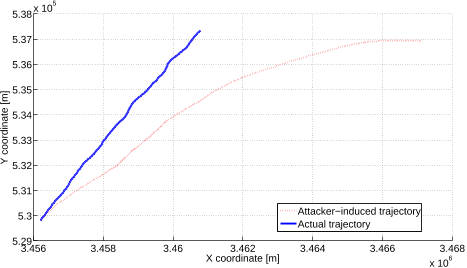

In [25]:
# load image
example = dataset[0]
image = example["image"]
image

In [26]:
# prepare image for the model
model.eval()

inputs = processor(images=image, return_tensors="pt", max_patches=512).to(device)

flattened_patches = inputs.flattened_patches
attention_mask = inputs.attention_mask

generated_ids = model.generate(flattened_patches=flattened_patches, attention_mask=attention_mask, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

the average number of iterations for the NUM different attacks.


## Load from the Hub

Once trained you can push the model and processor on the Hub to use them later. 
Meanwhile you can play with the model that we have fine-tuned!

In [27]:
model.push_to_hub("pix2struct-base-Sci-v2")
processor.push_to_hub("pix2struct-base-Sci-v2")
# processor.push_to_hub("pix2struct-base-Sci")

model.safetensors:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/851k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/astro21/pix2struct-base-Sci-v2/commit/101a265d322edcddf42c7f15369e75dc8f527069', commit_message='Upload processor', commit_description='', oid='101a265d322edcddf42c7f15369e75dc8f527069', pr_url=None, pr_revision=None, pr_num=None)

In [28]:
# import torch
# from transformers import Pix2StructForConditionalGeneration, AutoProcessor

# device = "cuda" if torch.cuda.is_available() else "cpu"

# model = Pix2StructForConditionalGeneration.from_pretrained("astro21/pix2struct-base-Sci").to(device)
# processor = AutoProcessor.from_pretrained("astro21/pix2struct-base-Sci")

Let's check the results on our train dataset!

In [29]:
import random

# Determine the desired size of the reduced training dataset
desired_test_size = int(len(dataset) * 0.00004)  # Reduce the size by 60%

# Randomly sample examples from the original training dataset to create the reduced training dataset
reduced_train_dataset = dataset.shuffle(seed=42).select(range(desired_test_size))


In [30]:
reduced_train_dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 4
})

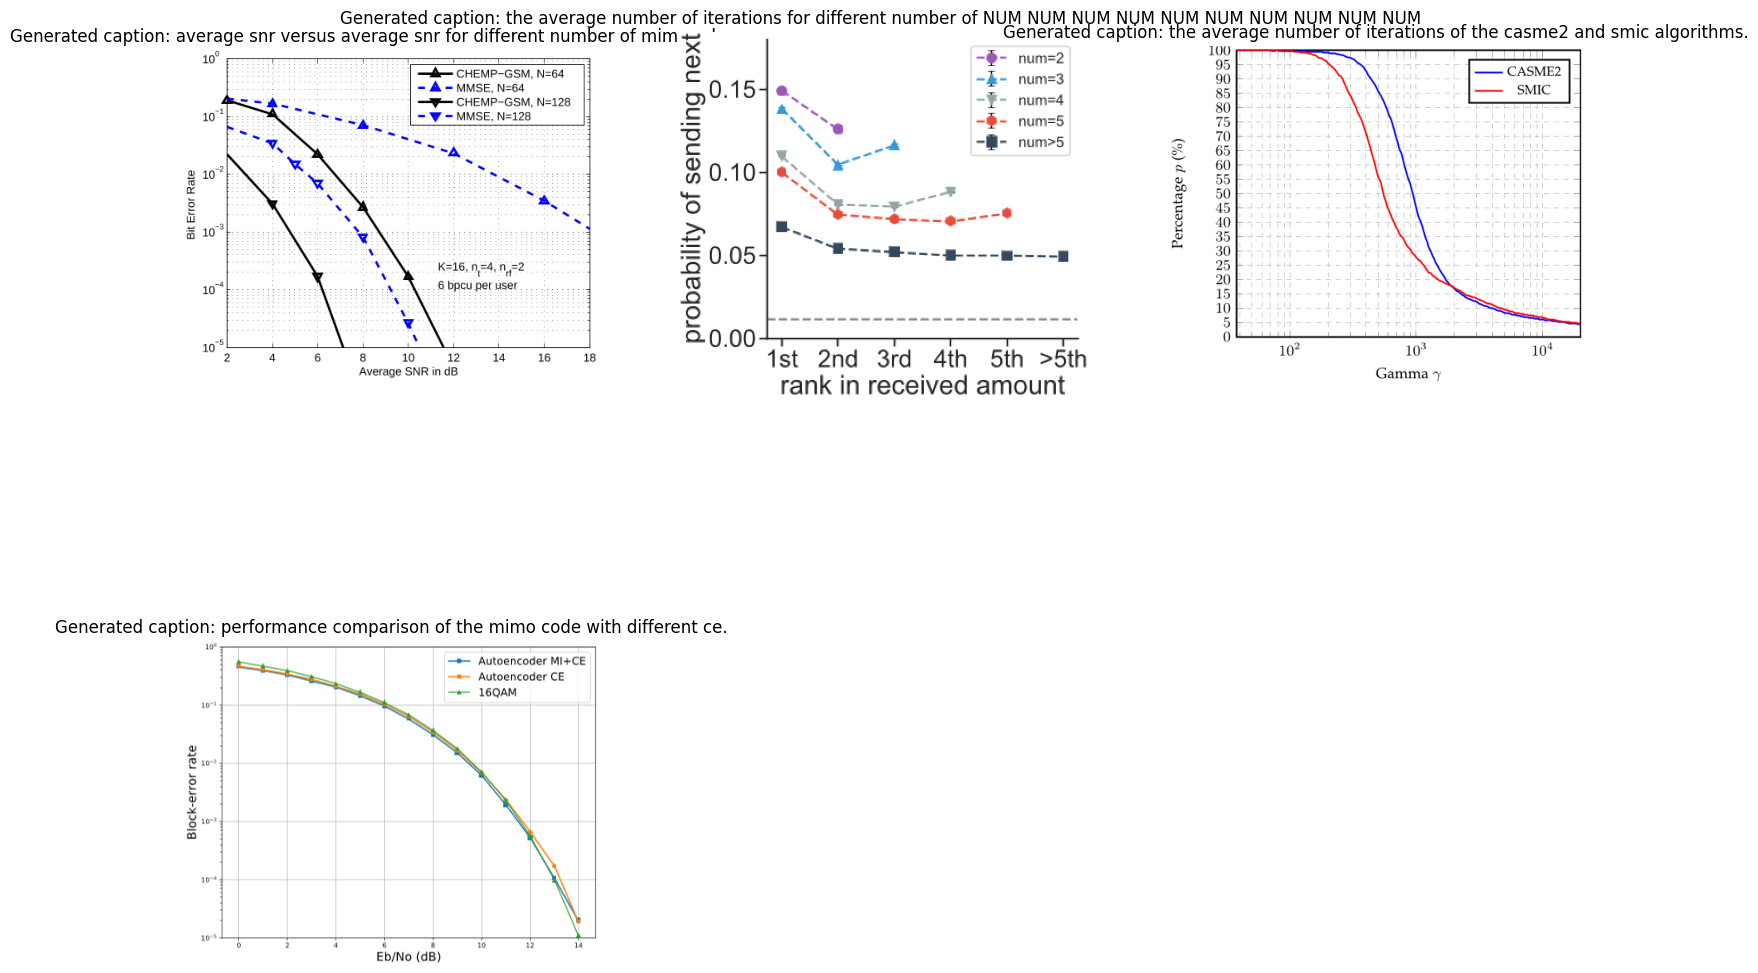

In [31]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(reduced_train_dataset):
    image = example["image"]
    inputs = processor(images=image, return_tensors="pt", max_patches=1024).to(device)
    flattened_patches = inputs.flattened_patches
    attention_mask = inputs.attention_mask

    generated_ids = model.generate(flattened_patches=flattened_patches, attention_mask=attention_mask, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    fig.add_subplot(2, 3, i+1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Generated caption: {generated_caption}")